# Combining Permafrost Observations with Modeled Historical Air Temperature Data from SNAP Data API

This notebook demonstrates how to take a set of monthly observations at a known sampling location and query the SNAP Data API for modeled historical monthly data at that location. In this example, CALM active layer thickness (ALT) observations made at the "Imnavait Creek WET" site (U11B: 68.611, -149.3145) in the month of August are paired with CRU-TS 4.0 mean August air temperature data accessed via the SNAP Data API. (References for these datasets are included at the bottom of this notebook.)



### Setup:
Import python packages. 

In [8]:
import pandas as pd
import requests
import matplotlib.pyplot as plt 

### Read in local dataset:

Using the ```pandas``` package, read in observed active layer thickness observations from a local CSV file, and convert the date column to a ```datetime``` object. 

Note that this dataset has been cleaned and reorganized from its original state into a tidier format for this analysis. The cleaned dataset has been subset to years 1995-2015 and includes only the last August ALT observation in each year. This subset should represent the mean grid-wide August ALT observed for each year.

In [9]:
u11b = pd.read_csv('./calm_u11b.csv')
u11b['DATE'] = pd.to_datetime(u11b['DATE'])
print(u11b)

         DATE  MEAN_ALT_CM  STDEV  MIN_ALT_CM  MAX_ALT_CM
0  1995-08-20        52.96   8.93        29.0        71.0
1  1996-08-20        54.13   9.63        29.0        81.0
2  1997-08-09        56.42   7.75        38.0        74.0
3  1998-08-13        54.46   7.79        39.0        81.0
4  1999-08-10        53.22   8.66        34.0        84.0
5  2000-08-08        45.22   8.78        25.0        73.0
6  2001-08-16        48.88   8.20        30.0        76.0
7  2002-08-20        39.35   8.23        22.0        59.0
8  2003-08-19        45.72   8.30        28.0        64.0
9  2004-08-17        50.62   6.46        37.0        78.0
10 2005-08-14        44.06   9.02        28.0        80.0
11 2006-08-13        49.03   7.41        36.0        77.0
12 2007-08-10        44.72   7.83        30.0        80.0
13 2008-08-15        45.23   8.42        27.0        76.0
14 2009-08-13        58.28   8.82        42.0        84.0
15 2010-08-15        63.90   8.68        47.0        90.0
16 2011-08-16 

### Query data using the SNAP Data API:

Using the sampling site location coordinates, we can construct a URL that will be used to fetch data from the SNAP Data API. According to the temperature endpoint [documentation](https://earthmaps.io/taspr/#:~:text=Monthly%20min%2C%20mean%2C%20and%20maximum%20temperature%20for%20each%20year%20(point%20query)), we can request min/mean/max air temperatures for all months and years using the following string construction:

```earthmaps.io/tas2km/point/<latitude>/<longitude>```



In [10]:
lat = "69.401"
lon = "-148.8056"

url = str("https://earthmaps.io/tas2km/point/" + lat + "/" + lon)

We can then use the ```requests``` package to fetch data from our custom URL, and parse the response to extract only the month (August) and years (1995-2015) that we want.

The code snippet below accomplishes the following:

1. Creates a session for sending requests. (This opens a persistent HTTP connection and allows making more than one request over that connection. In this example we only make one request to the SNAP Data API, but this step is included as a best practice for those wishing to adapt this code to make multiple requests.)
2. Checks for any non-data response. Anything but a code 200 indicates an error, and so if other codes are encountered we will print an explicit error message to identify the issue.
3. Creates an empty dictionary object ```aug_temps ``` to hold the data.
4. Loops through the years of interest and parses the response. We know the JSON structure from the [documentation](https://earthmaps.io/taspr/#:~:text=for%20the%20year%3E%2C%0A%20%20%20%20%20%20%7D%2C%0A%20%20%20%20%20%20...%0A%20%20%20%20%7D%2C%0A%20%20%20%20...%0A%20%20%7D%2C%0A%20%20...%0A%7D-,Monthly%20min%2C%20mean%2C%20and%20maximum%20temperature%20for%20each%20year,Results%20from%20monthly%20min%2C%20mean%2C%20and%20maximum%20temperature,-%7B%0A%20%20%22historical%22%3A%20%7B%0A%20%20%20%20%22CRU%2DTS), so we can extract just the data we need from the response without having to read the entire dataset into a table.

In [11]:
start_year = 1995
end_year = 2015

with requests.Session() as s:
    temp_response = s.get(url)
    if temp_response.status_code != 200:
            print("No data returned ...  coordinates may be out of bounds, or there may be a problem with the server.")
    else:
        aug_temps = {}
        for year in range(start_year, end_year+1):
            aug_temps[str(year)] = temp_response.json()["historical"]['CRU-TS']['historical']['August'][str(year)]['tasmean']

### Combine queried data with local dataset:

Now we can combine our original dataset with the August mean air temperature data. 

First, we add a blank column to hold the queried air temperature data. Then we iterate through each row in the table and use the year of the observation as a key in our ```aug_temps``` dictionary. The returned dictionary value is then written to the new blank column.

In [12]:
u11b["MEAN_AUG_TEMP"] = ""

for index, row in u11b.iterrows():
    year_key = str(row.DATE.year)
    u11b.loc[index, "MEAN_AUG_TEMP"] = aug_temps[year_key]

print(u11b)

         DATE  MEAN_ALT_CM  STDEV  MIN_ALT_CM  MAX_ALT_CM MEAN_AUG_TEMP
0  1995-08-20        52.96   8.93        29.0        71.0           9.7
1  1996-08-20        54.13   9.63        29.0        81.0           8.3
2  1997-08-09        56.42   7.75        38.0        74.0          11.7
3  1998-08-13        54.46   7.79        39.0        81.0          11.8
4  1999-08-10        53.22   8.66        34.0        84.0          12.6
5  2000-08-08        45.22   8.78        25.0        73.0           9.3
6  2001-08-16        48.88   8.20        30.0        76.0           9.7
7  2002-08-20        39.35   8.23        22.0        59.0           9.1
8  2003-08-19        45.72   8.30        28.0        64.0           9.6
9  2004-08-17        50.62   6.46        37.0        78.0          12.9
10 2005-08-14        44.06   9.02        28.0        80.0          11.7
11 2006-08-13        49.03   7.41        36.0        77.0           9.8
12 2007-08-10        44.72   7.83        30.0        80.0       

### Plot the data:

To visualize the relationship between grid-wide August mean ALT and August mean air temperatures, we will make a simple line plot using the ```matplotlib``` package. Using the date column for the X axis, we will plot ALT on the left Y axis and air temperature on the right Y axis.

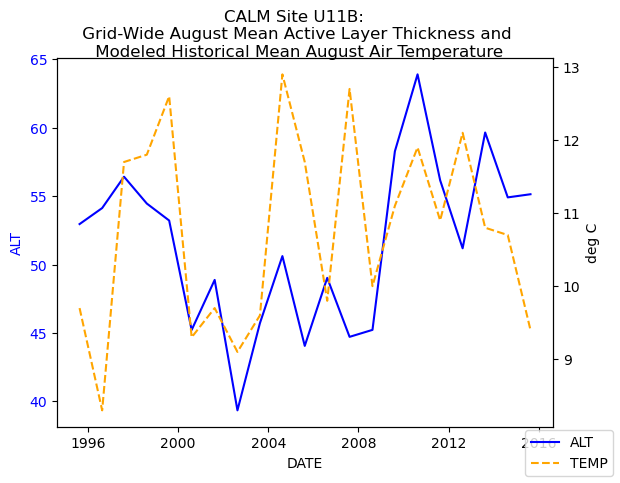

In [13]:
x = u11b['DATE']
y1 = u11b['MEAN_ALT_CM'].astype(float)
y2 = u11b['MEAN_AUG_TEMP'].astype(float)

fig, ax1 = plt.subplots()

ax1.set_xlabel('DATE')
ax1.set_ylabel('ALT', color='blue')
ax1.plot(x, y1, color='blue', label='ALT')
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx() 
ax2.set_ylabel('deg C')
ax2.plot(x, y2, color='orange', label="TEMP", linestyle='dashed')
ax2.tick_params(axis='y')

fig.legend(loc='lower right')
fig.suptitle("CALM Site U11B: \n Grid-Wide August Mean Active Layer Thickness and \n Modeled Historical Mean August Air Temperature")
plt.show()


### What do you think?

- **Is there a relationship here that warrants further exploration?**

- **What other datasets from the SNAP Data API could be combined with observed ALT?**

- **Could you use the processes demostrated in this notebook for your own work?**  

  

We would love to heard your thoughts! Please reach out to SNAP at ```uaf-snap-data-tools@alaska.edu``` with any questions, suggestions, or ideas for notebooks you would like to see featured on ARDAC.

### References and data sources:

- The CALM site data and metadata can be found here: [https://arcticdata.io/catalog/view/doi%3A10.18739%2FA2SF2MD3T](https://arcticdata.io/catalog/view/doi%3A10.18739%2FA2SF2MD3T)
...and here: [https://www2.gwu.edu/~calm/data/north.htm](https://www2.gwu.edu/~calm/data/north.htm)

- The CRU-TS 4.0 data and metadata can be found here: [https://catalog.snap.uaf.edu/geonetwork/srv/api/records/3b2b24ff-4916-4d92-95b7-c6b2fcefd381](https://catalog.snap.uaf.edu/geonetwork/srv/api/records/3b2b24ff-4916-4d92-95b7-c6b2fcefd381)
